In [1]:
import time

from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
import polars as pl

from plotly.subplots import make_subplots
from result import Result

from raft.io import read_file

from raft.utils.log import logger

from raft.tasks.message_parsing.data_types import MessageParseData

In [2]:
from raft.services.sirius_messages import (
    ImageCaptureMessage,
    
    SeabirdCTDMessage,
    AanderaaCTDMessage,
    EcopuckMessage,
    
    ParosciPressureMessage,
    TeledyneDVLMessage,
    LQModemMessage,
    EvologicsModemMessage,

    BatteryMessage,
    ThrusterMessage,
)

from raft.services.sirius_messages import (
    parse_message_header,
    parse_image_message,

    parse_seabird_ctd_message,
    parse_aanderaa_ctd_message,
    parse_ecopuck_message,

    parse_parosci_pressure_message,
    parse_teledyne_dvl_message,
    parse_lq_modem_message,
    parse_evologics_modem_message,

    parse_battery_message,
    parse_thruster_message,
)

### Load data

In [3]:
paths: dict = dict()

paths["datadir"] = Path("/media/martin/pcie_01/acfr_revisits_processed/acfr_merged_message_files")
paths["messages"] = paths["datadir"] / Path("qdc5ghs3_20130405_103429_messages.txt")

lines: list[str] = read_file(paths["messages"]).unwrap()


TOPIC_TO_PARSER: dict = {
    "LQMODEM": parse_lq_modem_message,
    "RDI": parse_teledyne_dvl_message,
}


def parse_messages(lines: list[str], parsers: dict) -> dict:
    """TODO"""
    parsed_messages: dict[type, object] = dict()
    
    for line in lines:
        header = parse_message_header(line).unwrap()

        if not header.topic in parsers:
            continue

        parsed: object = parsers[header.topic](line).unwrap()
        
        if not type(parsed) in parsed_messages:
            parsed_messages[type(parsed)] = list()
        else:
            parsed_messages[type(parsed)].append(parsed)
            
    return parsed_messages

parsed_messages: dict[type, list[object]] = parse_messages(lines, TOPIC_TO_PARSER)

for message_type, messages in parsed_messages.items():
    logger.info(f"{message_type}: {len(messages)}")

2024-06-07 14:45:50.199 | INFO     | __main__:<module>:37 - <class 'raft.services.sirius_messages.data_types.TeledyneDVLMessage'>: 25117
2024-06-07 14:45:50.200 | INFO     | __main__:<module>:37 - <class 'raft.services.sirius_messages.data_types.LQModemMessage'>: 216


### Define plot functions

In [4]:
def plot_lqmodem_scatter(data: pl.DataFrame) -> None:
    """TODO"""
    fig = px.scatter_mapbox(
        data,
        lat="latitude",
        lon="longitude",
        color="timestamp",
        size_max=15,
        zoom=16,
        height=600,
        hover_data={"time", "range"},
    )
    fig.update_layout(height=800, width=1000, mapbox_style="open-street-map")
    return fig


def plot_lqmodem_timeseries(data: pl.DataFrame) -> None:
    """TODO"""
    fig = make_subplots(
        rows=7, 
        cols=1, 
        subplot_titles=("Latitude", "Longitude", "Heading", "Pitch", "Roll", "Bearing", "Range")
    )
    
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["latitude"],), row=1, col=1,)
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["longitude"],), row=2, col=1,)
    
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["heading"],), row=3, col=1,)
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["pitch"],), row=4, col=1,)
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["roll"],), row=5, col=1,)
    
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["bearing"],), row=6, col=1,)
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["range"],), row=7, col=1,)
    
    fig.update_layout(height=800, width=1000, title_text="LQ Modem Timeseries")
    
    return fig

def plot_teledyne_dvl_timeseries(data: pl.DataFrame) -> None:
    """TODO"""
    fig = make_subplots(
        rows=3, 
        cols=1, 
        subplot_titles=("Heading", "Pitch", "Roll")
    )
    
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["heading"],), row=1, col=1,)
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["pitch"],), row=2, col=1,)
    fig.append_trace(go.Scatter(x=data["timestamp"], y=data["roll"],), row=3, col=1,)
    
    fig.update_layout(height=800, width=1000, title_text="LQ Modem Timeseries")
    
    return fig

### Format LQ Modem messages

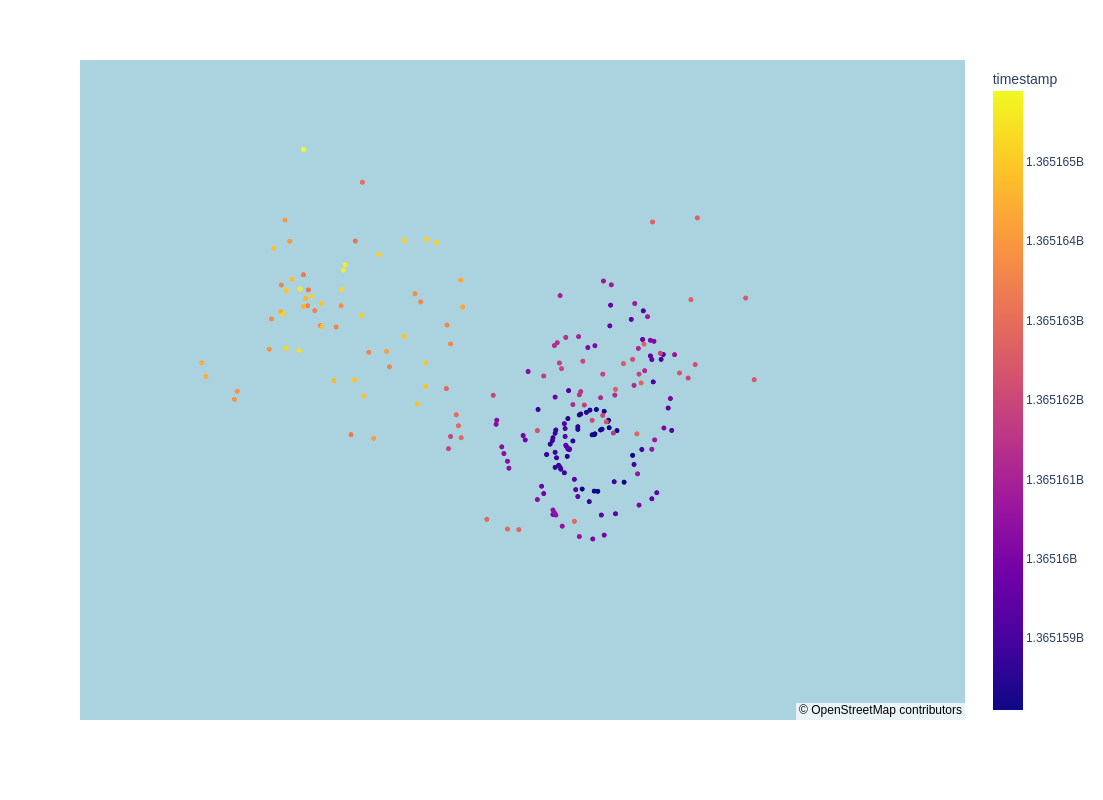

In [5]:
data: dict = dict()
data["usbl"]: pl.DataFrame = pl.DataFrame([
    {
        "topic": message.header.topic,
        "timestamp": message.header.timestamp,
        
        "latitude": message.body.latitude,
        "longitude": message.body.longitude,
        
        "heading": message.body.heading,
        "pitch": message.body.pitch,
        "roll": message.body.roll,
        
        "time": message.body.time,
        "bearing": message.body.bearing,
        "range": message.body.range,
        
    } for message in parsed_messages[LQModemMessage]
])

data["dvl"]: pl.DataFrame = pl.DataFrame([
    {
        "topic": message.header.topic,
        "timestamp": message.header.timestamp,
        
        "heading": message.body.heading,
        "pitch": message.body.pitch,
        "roll": message.body.roll,
        
    } for message in parsed_messages[TeledyneDVLMessage]
])

figs: dict = dict()
figs["usbl_scatter"] = plot_lqmodem_scatter(data["usbl"])
figs["usbl_scatter"].show()

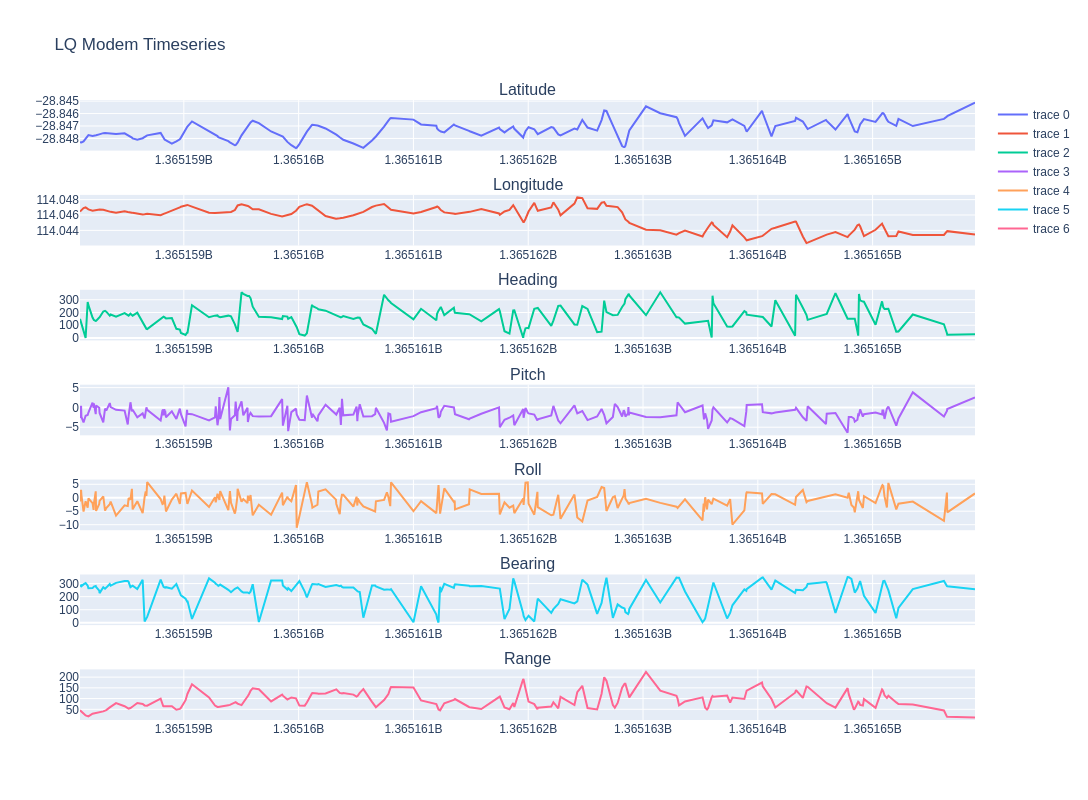

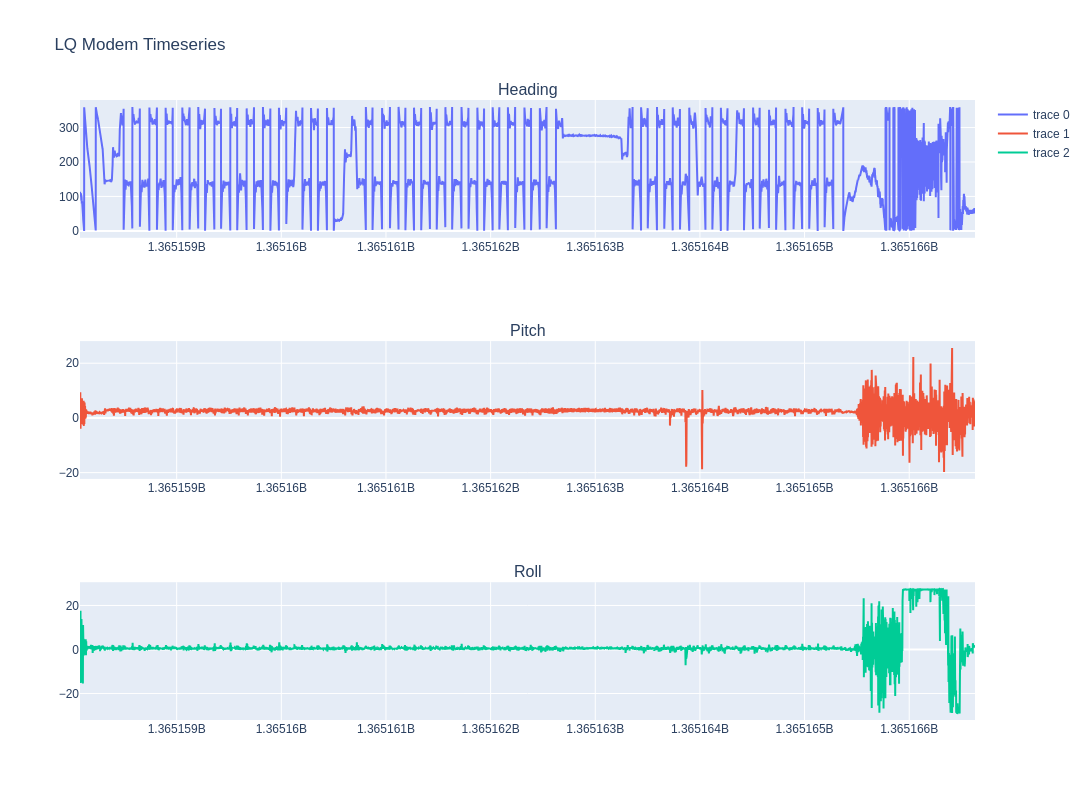

In [6]:
figs["usbl_series"] = plot_lqmodem_timeseries(data["usbl"])
figs["usbl_series"].show()

figs["dvl_series"] = plot_teledyne_dvl_timeseries(data["dvl"])
figs["dvl_series"].show()